In [18]:
import os
import json
import random
import math
from tqdm.notebook import tqdm
import warnings
import gc

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import f1_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization, Lambda, MaxPooling1D, Conv1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential, load_model
import tensorflow.keras.backend as K

weight1 = np.array([1,1,0,0])
weight2 = np.array([0,0,1,1])
def my_loss(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult))
def my_loss_E1(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred)*weight1)/2e+04
def my_loss_E2(y_true, y_pred):
    divResult = Lambda(lambda x: x[0]/x[1])([(y_pred-y_true),(y_true+0.000001)])
    return K.mean(K.square(divResult)*weight2)
def kaeri_metric(y_true, y_pred):
    return 0.5 * E1(y_true, y_pred) + 0.5 * E2(y_true, y_pred)
def E1(y_true, y_pred):
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)
def E2(y_true, y_pred):
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))
def E2M(y_true, y_pred):
    _t, _p = np.array(y_true)[:,2], np.array(y_pred)[:,2]
    return np.mean(np.square((_t - _p) / (_t + 1e-06)))
def E2V(y_true, y_pred):
    _t, _p = np.array(y_true)[:,3], np.array(y_pred)[:,3]
    return np.mean(np.square((_t - _p) / (_t + 1e-06)))

In [4]:
def read_data(window_sizes=[[], [], []]):
    train_df = pd.read_csv('../data/train_features.csv')
    target_df = pd.read_csv('../data/train_target.csv')
    test_df = pd.read_csv('../data/test_features.csv')
    train_df = train_df[train_df.index%375<thres].reset_index(drop=True)
    test_df = test_df[test_df.index%375<thres].reset_index(drop=True)

    X_train_l, X_test_l = [], []
    Y_train = target_df.values[:, 1:]

    # making XY
    train = train_df.copy()
    test = test_df.copy()
    for col in ['S1', 'S2', 'S3', 'S4']:
        train[f'speed_{col}'] = train.groupby('id')[col].cumsum().abs().values
        test[f'speed_{col}'] = test.groupby('id')[col].cumsum().abs().values
    train, test = normalize(train, test)
    train = lag_with_pct_change0(train, window_sizes[0])
    test = lag_with_pct_change0(test, window_sizes[0])

    X_train = train.values.reshape((2800,thres,-1,1))
    X_test = test.values.reshape((700,thres,-1,1))
    X_train_l += [X_train]
    X_test_l += [X_test]

    # making M
    train = train_df.copy()
    test = test_df.copy()
    for col in ['S1', 'S2', 'S3', 'S4']:
        train[f'speed_{col}'] = train.groupby('id')[col].cumsum().abs().values
        test[f'speed_{col}'] = test.groupby('id')[col].cumsum().abs().values
    train, test = normalize(train, test)
    train = lag_with_pct_change1(train, window_sizes[1])
    test = lag_with_pct_change1(test, window_sizes[1])

    X_train = train.values.reshape((2800,thres,-1,1))
    X_test = test.values.reshape((700,thres,-1,1))
    X_train_l += [X_train]
    X_test_l += [X_test]

    # making V
    train = train_df.copy()
    test = test_df.copy()

    train, test = normalize(train, test)
    train = lag_with_pct_change2(train, window_sizes[2])
    test = lag_with_pct_change2(test, window_sizes[2])
    
    X_train = train.values.reshape((2800,thres,-1,1))
    X_test = test.values.reshape((700,thres,-1,1))
    X_train_l += [X_train]
    X_test_l += [X_test]

    for i in range(3):
        if i==0:
            print(f'Y_train.shape : {Y_train.shape}')
        print(f'train shape {i} : {X_train_l[i].shape}, test shape {i} : {X_test_l[i].shape}')
    return X_train_l, Y_train, X_test_l

In [5]:
def lag_with_pct_change0(df, windows=[]):
    for window in [1, 2, 3]:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df['signal_shift_pos_' + str(window) + col] = df.groupby('id')[col].shift(window).fillna(0)
            df['signal_shift_neg_' + str(window) + col] = df.groupby('id')[col].shift(-1 * window).fillna(0)
    for window in windows:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df[f'{col}_{window}_mean'] = df.groupby('id')[col].rolling(window=window).mean().values
            df[f'{col}_{window}_std'] = df.groupby('id')[col].rolling(window=window).std().values
            df[f'{col}_{window}_var'] = df.groupby('id')[col].rolling(window=window).var().values
            df[f'{col}_{window}_max'] = df.groupby('id')[col].rolling(window=window).max().values
            df[f'{col}_{window}_min'] = df.groupby('id')[col].rolling(window=window).min().values
    df.drop(columns='id', inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    return df
##############################################################################################################################
def lag_with_pct_change1(df, windows=[]):
    for window in [1, 2, 3]:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df['signal_shift_pos_' + str(window) + col] = df.groupby('id')[col].shift(window).fillna(0)
            df['signal_shift_neg_' + str(window) + col] = df.groupby('id')[col].shift(-1 * window).fillna(0)
        for col in [f'speed_{c}' for c in ['S1', 'S2', 'S3', 'S4']]:
            df['signal_shift_pos_' + str(window) + col] = df.groupby('id')[col].shift(window).fillna(0)
            df['signal_shift_neg_' + str(window) + col] = df.groupby('id')[col].shift(-1 * window).fillna(0)
    for window in windows:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df[f'{col}_{window}_mean'] = df.groupby('id')[col].rolling(window=window).mean().values
            df[f'{col}_{window}_std'] = df.groupby('id')[col].rolling(window=window).std().values
            df[f'{col}_{window}_var'] = df.groupby('id')[col].rolling(window=window).var().values
            df[f'{col}_{window}_max'] = df.groupby('id')[col].rolling(window=window).max().values
            df[f'{col}_{window}_min'] = df.groupby('id')[col].rolling(window=window).min().values
    df.drop(columns='id', inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    return df
##############################################################################################################################
def lag_with_pct_change2(df, windows=[]):
    for window in windows:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df[f'{col}_{window}_mean'] = df.groupby('id')[col].rolling(window=window).mean().values
            df[f'{col}_{window}_max'] = df.groupby('id')[col].rolling(window=window).max().values
            df[f'{col}_{window}_min'] = df.groupby('id')[col].rolling(window=window).min().values
    df.drop(columns=['id'], inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    return df
##############################################################################################################################
def normalize(train, test):
    if 'S1' in train.columns:
        for col in ['Time', 'S1', 'S2', 'S3', 'S4']:
            train_input_mean = train[col].mean()
            train_input_sigma = train[col].std()
            train[col] = (train[col] - train_input_mean) / train_input_sigma
            test[col] = (test[col] - train_input_mean) / train_input_sigma
    if 'speed_S1' in train.columns:
        for col in ['speed_S1', 'speed_S2', 'speed_S3', 'speed_S4']:
            train_input_mean = train[col].mean()
            train_input_sigma = train[col].std()
            train[col] = (train[col] - train_input_mean) / train_input_sigma
            test[col] = (test[col] - train_input_mean) / train_input_sigma
    return train, test

In [6]:
def set_model(train_target, nf=16):  # 0:x,y, 1:m, 2:v
    activation = 'elu'
    padding = 'valid'
    model = Sequential()
    
    fs = (3,1)

    model.add(Conv2D(nf,fs, padding=padding, activation=activation, input_shape=X_train_l[train_target].shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*2,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*4,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*8,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*16,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*32,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Flatten())
    model.add(Dense(128, activation ='elu'))
    model.add(Dense(64, activation ='elu'))
    model.add(Dense(32, activation ='elu'))
    model.add(Dense(16, activation ='elu'))
    model.add(Dense(4))

    optimizer = keras.optimizers.Adam()

    global weight2
    if train_target == 1: # only for M
        weight2 = np.array([0,0,1,0])
    else: # only for V
        weight2 = np.array([0,0,0,1])
       
    if train_target==0:
        model.compile(loss=my_loss_E1, optimizer=optimizer,)
    else:
        model.compile(loss=my_loss_E2,optimizer=optimizer,)
       
    return model

In [8]:
%%time
thres=200
N_FOLDS=5
MODEL_SAVE_FOLDER_PATH = ''

SEED=42

ws = [[30], [10, 50], [30]]
X_train_l, Y_train, X_test_l = read_data(window_sizes=ws)

Y_train.shape : (2800, 4)
train shape 0 : (2800, 200, 53, 1), test shape 0 : (700, 200, 53, 1)
train shape 1 : (2800, 200, 97, 1), test shape 1 : (700, 200, 97, 1)
train shape 2 : (2800, 200, 17, 1), test shape 2 : (700, 200, 17, 1)
CPU times: user 1min 20s, sys: 4.86 s, total: 1min 25s
Wall time: 1min 24s


In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def plot_error(type_id,pred,true):
    print(pred.shape)

    if type_id == 0:
        _name = 'x_pos'
    elif type_id == 1:
        _name = 'y_pos'
    elif type_id == 2:
        _name = 'mass'
    elif type_id == 3:
        _name = 'velocity'
    elif type_id == 4:
        _name = "distance"
    else:
        _name = 'error'

    x_coord = np.arange(1,pred.shape[0]+1,1)
    if type_id < 2:
        Err_m = (pred[:,type_id] - true[:,type_id])
    elif type_id < 4:
        Err_m = ((pred[:,type_id] - true[:,type_id])/true[:,type_id])*100
    else:
        Err_m = ((pred[:,0]-true[:,0])**2+(pred[:,1]-true[:,1])**2)**0.5

    fig = plt.figure(figsize=(8,6))
    plt.rcParams["font.size"]=15
    plt.scatter(x_coord, Err_m, marker='o')
    plt.title("%s Prediction for Training Data" % _name, size=20)
    plt.xlabel("Data ID", labelpad=10, size=20)
    plt.ylabel("Prediction Error of %s," % _name, labelpad=10, size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylim(-100., 100.)
    plt.xlim(0, pred.shape[0]+1)
    plt.show()
    print('std : {}, max : {}, min : {}'.format(np.std(Err_m), np.max(Err_m), np.min(Err_m)))
    return Err_m

def train(model,X,Y,train_target,n_fold=5,fold=0,seed=42):
    best_save = ModelCheckpoint(MODEL_SAVE_FOLDER_PATH + f'best_m{train_target}_{fold}.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.00001, verbose=1)

    kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
    splits = [[i,j] for i,j in kf.split(X)]
    tt, tt_target = X[splits[fold][0]], Y[splits[fold][0]]
    vv, vv_target = X[splits[fold][1]], Y[splits[fold][1]]
    
    EPOCHS=500 if train_target==2 else 300
    history = model.fit(tt, tt_target, validation_data=(vv, vv_target),
                  epochs=EPOCHS,
                  batch_size=512,
                  shuffle=True,
                  verbose = 2,
                  callbacks=[es, best_save, reduce_lr], )

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.axvline(x=np.argmin(history.history['val_loss']), color='b', linewidth=1)
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()    
    
    return model
def load_best_model(train_target, fold=0):
    if train_target == 0:
        model = load_model(MODEL_SAVE_FOLDER_PATH + f'best_m{train_target}_{fold}.hdf5', custom_objects={'my_loss_E1': my_loss, })
    else:
        model = load_model(MODEL_SAVE_FOLDER_PATH + f'best_m{train_target}_{fold}.hdf5', custom_objects={'my_loss_E2': my_loss, })

    score = model.evaluate(X_train_l[train_target], Y_train, verbose=0)
    print('loss:', score)

    pred = model.predict(X_train_l[train_target])
    i=0
    print(f'정답(original): {Y_train[i]}, 예측값(original):, {pred[i]}')
    print(f'E1 : {E1(Y_train, pred)}, E2 : {E2(Y_train, pred)}, E2M : {E2M(Y_train, pred)}, E2v : {E2V(Y_train, pred)}')
    
    if train_target ==0:
        plot_error(4,pred,Y_train)
    elif train_target ==1:
        plot_error(2,pred,Y_train)
    elif train_target ==2:
        plot_error(3,pred,Y_train)    
    
    return model, [E1(Y_train, pred), E2(Y_train, pred), E2M(Y_train, pred), E2V(Y_train, pred)]

Epoch 1/300
5/5 - 1s - loss: 1.4728 - val_loss: 1.5648 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.8865 - val_loss: 1.4397 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.5872 - val_loss: 1.2405 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.3353 - val_loss: 1.0357 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.1356 - val_loss: 0.8012 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0443 - val_loss: 0.6506 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0255 - val_loss: 0.5530 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0184 - val_loss: 0.5039 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0115 - val_loss: 0.4734 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0078 - val_loss: 0.4287 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 0.0068 - val_loss: 0.4094 - lr: 0.0010
Epoch 12/300
5/5 - 1s - loss: 0.0062 - val_loss: 0.3580 - lr: 0.0010
Epoch 13/300
5/5 - 1s - loss: 0.0042 - val_loss: 0.3415 - lr: 0.0010
Epoch 14/300
5/5 - 1s - loss: 0.0034 - val_loss: 0.3407 - lr: 0.0010
Epoch 15/300
5/5 - 1s - loss: 0.0041 - val_

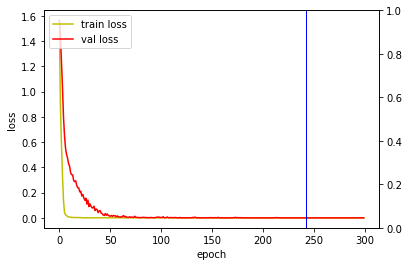

loss: 67640029184.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [   1.8806646 -398.71774    -64.27724   -189.12506  ]
E1 : 0.00015148369685736928, E2 : 231836.6496718182, E2M : 3.975316934113429, E2v : 231832.67435488408
(2800, 4)


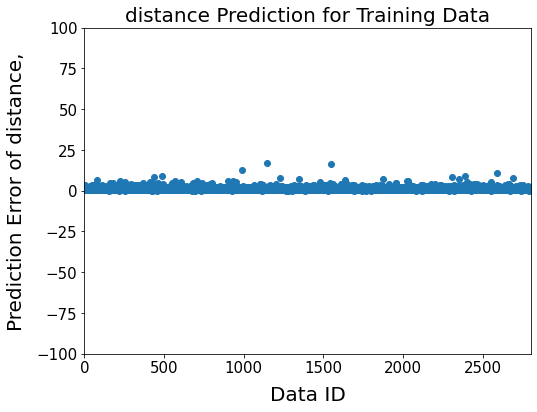

std : 1.0716657122715942, max : 17.268693885097665, min : 0.013382297281033611
################################################################################ target : 0, fold : 0 ################################################################################
Epoch 1/300
5/5 - 1s - loss: 1.4594 - val_loss: 1.5869 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.6733 - val_loss: 1.4125 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.1347 - val_loss: 1.1951 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.0553 - val_loss: 1.0304 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.0287 - val_loss: 0.9453 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0155 - val_loss: 0.8216 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0097 - val_loss: 0.6980 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0071 - val_loss: 0.6317 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0056 - val_loss: 0.5667 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0047 - val_loss: 0.4817 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 0.0033 - val_loss: 0.4386 -

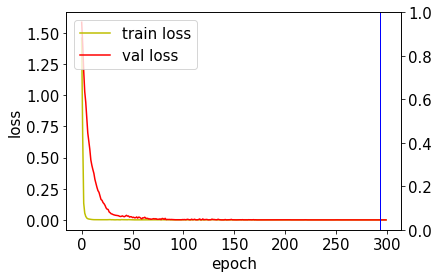

loss: 39522721792.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [   0.8437311 -401.0783     376.4137    -204.81186  ]
E1 : 0.0001530945727983047, E2 : 170851.47040227512, E2M : 21.95454536517412, E2v : 170829.51585690991
(2800, 4)


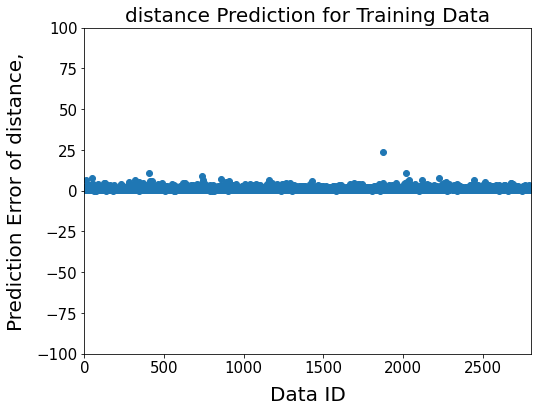

std : 1.074628036767882, max : 23.552703532148836, min : 0.027885419268935126
################################################################################ target : 0, fold : 1 ################################################################################
Epoch 1/300
5/5 - 1s - loss: 1.4629 - val_loss: 1.4733 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.8073 - val_loss: 1.3299 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.4096 - val_loss: 1.0865 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.1204 - val_loss: 0.8861 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.0574 - val_loss: 0.7310 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0333 - val_loss: 0.6305 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0249 - val_loss: 0.5401 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0156 - val_loss: 0.4941 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0110 - val_loss: 0.4619 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0086 - val_loss: 0.4202 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 0.0053 - val_loss: 0.3924 - 

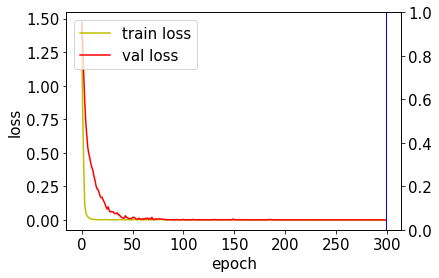

loss: 58739793920.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [   0.9048095 -399.63147   -667.2932    -302.6232   ]
E1 : 0.00013454147024642317, E2 : 525707.0686416432, E2M : 56.54677443761525, E2v : 525650.5218672055
(2800, 4)


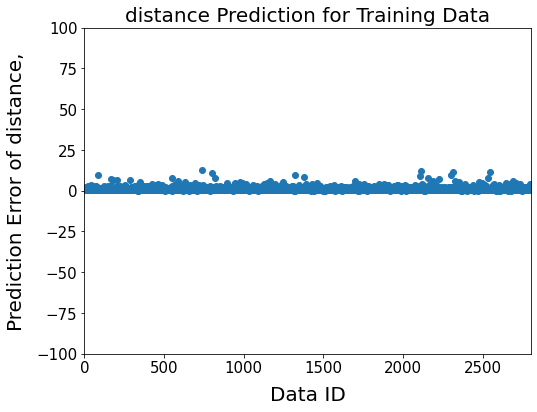

std : 1.038233552482944, max : 12.524789012537422, min : 0.016845597023544906
################################################################################ target : 0, fold : 2 ################################################################################
Epoch 1/300
5/5 - 1s - loss: 1.3943 - val_loss: 1.5252 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.6316 - val_loss: 1.4426 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.2163 - val_loss: 1.1423 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.0698 - val_loss: 0.9342 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.0324 - val_loss: 0.7912 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0204 - val_loss: 0.6675 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0136 - val_loss: 0.5831 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0104 - val_loss: 0.5436 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0074 - val_loss: 0.5124 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0071 - val_loss: 0.4739 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 0.0050 - val_loss: 0.4190 - 

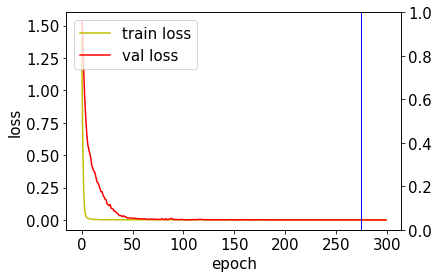

loss: 48158806016.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [  -1.5132238 -400.62357    283.0047      17.926146 ]
E1 : 0.00017689967414993756, E2 : 280503.36615963746, E2M : 69.88178988790052, E2v : 280433.4843697495
(2800, 4)


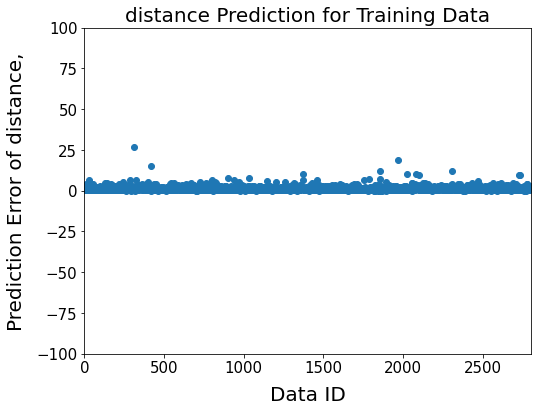

std : 1.2207489571365142, max : 27.016213327376445, min : 0.026426715340768573
################################################################################ target : 0, fold : 3 ################################################################################
Epoch 1/300
5/5 - 1s - loss: 1.4536 - val_loss: 1.4378 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.6812 - val_loss: 1.2098 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.2069 - val_loss: 0.9123 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.0844 - val_loss: 0.8932 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.0377 - val_loss: 0.6884 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0294 - val_loss: 0.5798 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0152 - val_loss: 0.5873 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0117 - val_loss: 0.5524 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0079 - val_loss: 0.4685 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0065 - val_loss: 0.4664 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 0.0061 - val_loss: 0.4255 -

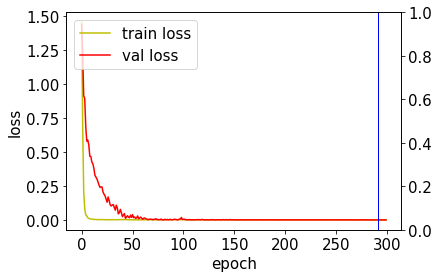

loss: 62215208960.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [ 1.0180937e-02 -3.9762500e+02 -5.4694391e+02 -2.8664008e+02]
E1 : 0.00014548138607096097, E2 : 444814.97569683875, E2M : 59.811279409782756, E2v : 444755.16441742895
(2800, 4)


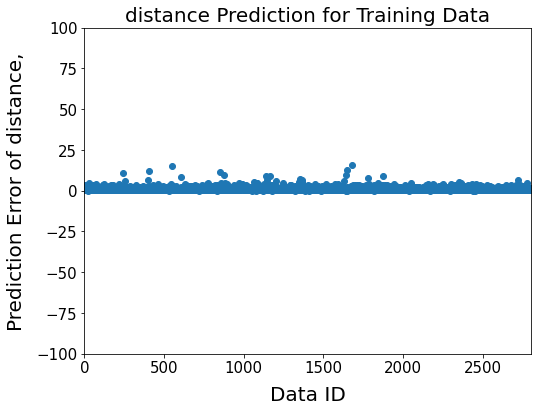

std : 1.079349962211574, max : 15.62068826970596, min : 0.01660947050352442
################################################################################ target : 0, fold : 4 ################################################################################
Epoch 1/300
5/5 - 2s - loss: 0.1550 - val_loss: 0.2073 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.0370 - val_loss: 0.2220 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.0183 - val_loss: 0.1983 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.0091 - val_loss: 0.1893 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.0061 - val_loss: 0.1942 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0056 - val_loss: 0.1726 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0046 - val_loss: 0.1695 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0024 - val_loss: 0.1665 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0019 - val_loss: 0.1587 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0014 - val_loss: 0.1576 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 0.0013 - val_loss: 0.1539 - lr

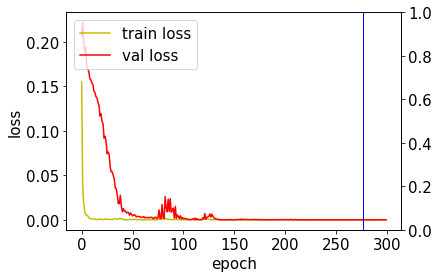

loss: 440457620357120.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [-76.33547  -10.05417   50.144485 -69.79251 ]
E1 : 7.3861925882705455, E2 : 80878.87186525913, E2M : 4.582490642803785e-05, E2v : 80878.87181943424
(2800, 4)


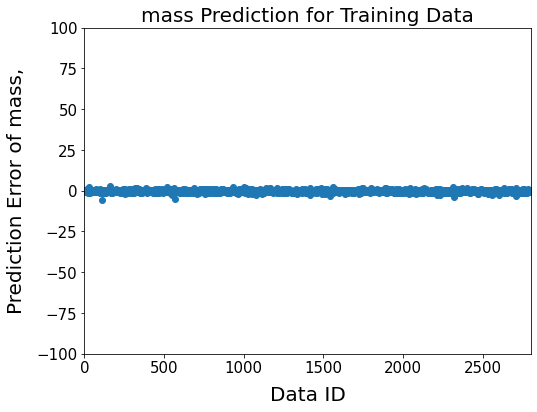

std : 0.6286961676778043, max : 2.830330984933036, min : -5.5269775390625
################################################################################ target : 1, fold : 0 ################################################################################
Epoch 1/300
5/5 - 1s - loss: 0.1446 - val_loss: 0.2087 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.0377 - val_loss: 0.2068 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.0150 - val_loss: 0.1809 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.0092 - val_loss: 0.1657 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.0076 - val_loss: 0.1530 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0034 - val_loss: 0.1355 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0021 - val_loss: 0.1227 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0019 - val_loss: 0.1175 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0017 - val_loss: 0.1078 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0013 - val_loss: 0.0954 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 8.0949e-04 - val_loss: 0.0891 - 

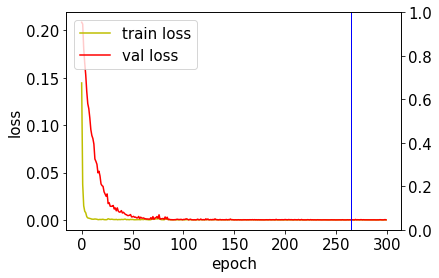

loss: 248405221703680.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [34.089573   6.755995  50.15648    4.5077376]
E1 : 7.279055677893744, E2 : 12965.095993281593, E2M : 2.9760268049163554e-05, E2v : 12965.095963521324
(2800, 4)


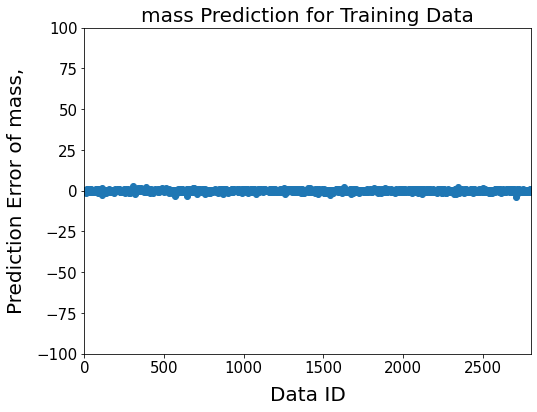

std : 0.5374602658919023, max : 3.1440226236979165, min : -3.6877528599330356
################################################################################ target : 1, fold : 1 ################################################################################
Epoch 1/300
5/5 - 1s - loss: 0.1606 - val_loss: 0.2054 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.0403 - val_loss: 0.2185 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.0160 - val_loss: 0.1981 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.0075 - val_loss: 0.1935 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.0049 - val_loss: 0.1837 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0032 - val_loss: 0.1740 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0029 - val_loss: 0.1716 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0021 - val_loss: 0.1692 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0027 - val_loss: 0.1638 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0020 - val_loss: 0.1582 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 0.0015 - val_loss: 0.1492 - 

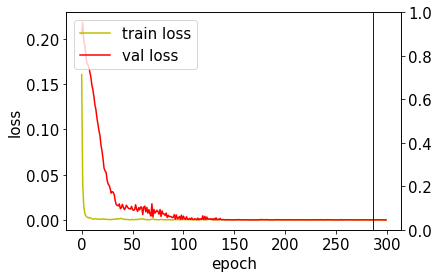

loss: 275812146216960.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [ 39.0329    -12.619299   49.867817    3.3546467]
E1 : 7.056000405378649, E2 : 536.1118875196685, E2M : 4.458505131104843e-05, E2v : 536.1118429346171
(2800, 4)


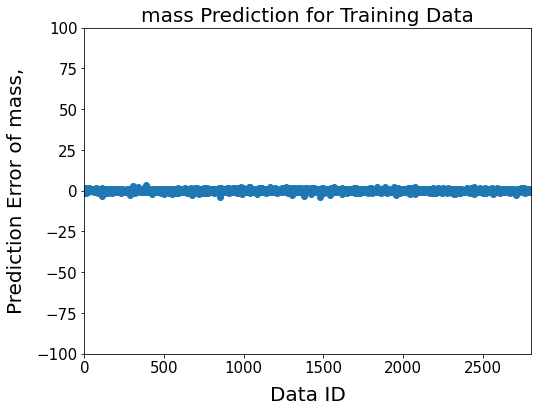

std : 0.6650259749381534, max : 3.6318664550781246, min : -3.8493118286132812
################################################################################ target : 1, fold : 2 ################################################################################
Epoch 1/300
5/5 - 1s - loss: 0.1160 - val_loss: 0.2108 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.0274 - val_loss: 0.2100 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.0103 - val_loss: 0.2073 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.0071 - val_loss: 0.1914 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.0037 - val_loss: 0.1768 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0030 - val_loss: 0.1661 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0022 - val_loss: 0.1519 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0017 - val_loss: 0.1403 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0012 - val_loss: 0.1249 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0014 - val_loss: 0.1151 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 0.0011 - val_loss: 0.1078 - 

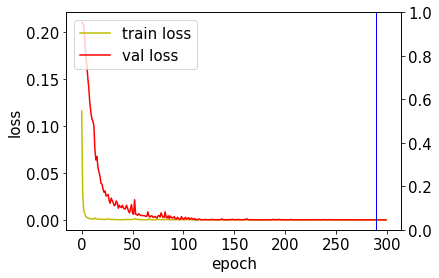

loss: 1373242644234240.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [-75.64042   11.708666  49.459824 -48.216503]
E1 : 9.135394121502184, E2 : 178413.78793069813, E2M : 3.92381562015538e-05, E2v : 178413.78789145997
(2800, 4)


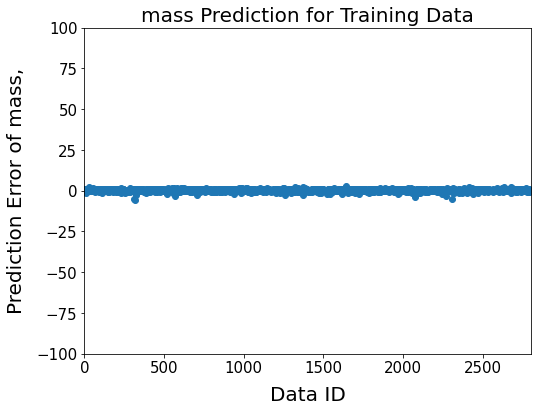

std : 0.5683106522156581, max : 2.7519073486328125, min : -5.641532897949219
################################################################################ target : 1, fold : 3 ################################################################################
Epoch 1/300
5/5 - 1s - loss: 0.1342 - val_loss: 0.1970 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.0313 - val_loss: 0.1971 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.0155 - val_loss: 0.1867 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.0072 - val_loss: 0.1877 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.0038 - val_loss: 0.1786 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0033 - val_loss: 0.1788 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0026 - val_loss: 0.1710 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0021 - val_loss: 0.1683 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0017 - val_loss: 0.1608 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0013 - val_loss: 0.1575 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 0.0011 - val_loss: 0.1504 - l

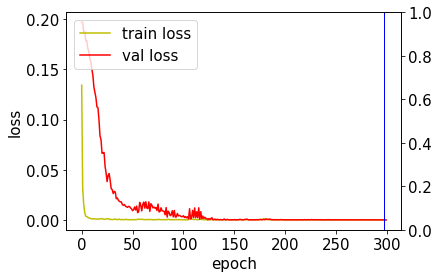

loss: 61106978553856.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [-19.537386  -8.291041  49.574627 -34.398594]
E1 : 7.013978323885996, E2 : 55654.958164788295, E2M : 3.7288614163066466e-05, E2v : 55654.95812749968
(2800, 4)


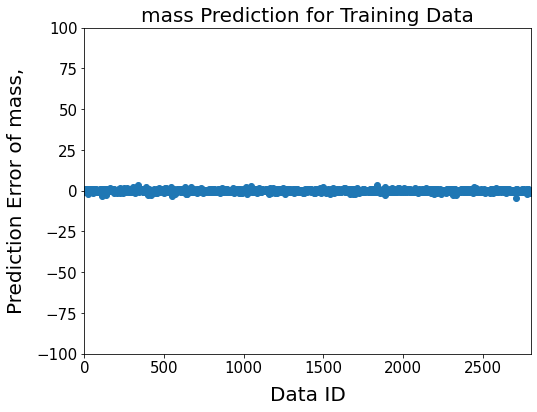

std : 0.6077536584555827, max : 3.230377197265625, min : -4.217729840959821
################################################################################ target : 1, fold : 4 ################################################################################
Epoch 1/500
5/5 - 1s - loss: 8.4671 - val_loss: 0.1989 - lr: 0.0010
Epoch 2/500
5/5 - 0s - loss: 0.0985 - val_loss: 0.0453 - lr: 0.0010
Epoch 3/500
5/5 - 0s - loss: 0.0352 - val_loss: 0.0359 - lr: 0.0010
Epoch 4/500
5/5 - 0s - loss: 0.0165 - val_loss: 0.0336 - lr: 0.0010
Epoch 5/500
5/5 - 0s - loss: 0.0082 - val_loss: 0.0395 - lr: 0.0010
Epoch 6/500
5/5 - 0s - loss: 0.0080 - val_loss: 0.0445 - lr: 0.0010
Epoch 7/500
5/5 - 0s - loss: 0.0050 - val_loss: 0.0447 - lr: 0.0010
Epoch 8/500
5/5 - 0s - loss: 0.0035 - val_loss: 0.0520 - lr: 0.0010
Epoch 9/500
5/5 - 0s - loss: 0.0024 - val_loss: 0.0538 - lr: 0.0010
Epoch 10/500
5/5 - 0s - loss: 0.0020 - val_loss: 0.0552 - lr: 0.0010
Epoch 11/500
5/5 - 0s - loss: 0.0017 - val_loss: 0.0545 - lr

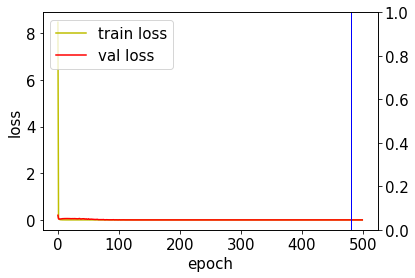

loss: 93996007424.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [ 0.3602678  -1.1892102  -1.6164147   0.39522758]
E1 : 6.6446809786147245, E2 : 1.0499623388611456, E2M : 1.049748947256584, E2v : 0.0002133916045619839
(2800, 4)


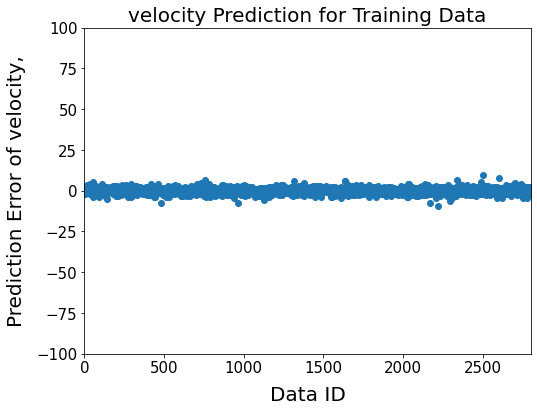

std : 1.4576242930565824, max : 9.449967741966242, min : -9.398621320724487
################################################################################ target : 2, fold : 0 ################################################################################
Epoch 1/500
5/5 - 0s - loss: 4.8845 - val_loss: 0.0746 - lr: 0.0010
Epoch 2/500
5/5 - 0s - loss: 0.1426 - val_loss: 0.0960 - lr: 0.0010
Epoch 3/500
5/5 - 0s - loss: 0.0502 - val_loss: 0.1662 - lr: 0.0010
Epoch 4/500
5/5 - 0s - loss: 0.0368 - val_loss: 0.2113 - lr: 0.0010
Epoch 5/500
5/5 - 0s - loss: 0.0226 - val_loss: 0.1835 - lr: 0.0010
Epoch 6/500
5/5 - 0s - loss: 0.0121 - val_loss: 0.1574 - lr: 0.0010
Epoch 7/500
5/5 - 0s - loss: 0.0095 - val_loss: 0.1231 - lr: 0.0010
Epoch 8/500
5/5 - 0s - loss: 0.0064 - val_loss: 0.1122 - lr: 0.0010
Epoch 9/500
5/5 - 0s - loss: 0.0054 - val_loss: 0.0940 - lr: 0.0010
Epoch 10/500
5/5 - 0s - loss: 0.0053 - val_loss: 0.0726 - lr: 0.0010
Epoch 11/500
5/5 - 0s - loss: 0.0039 - val_loss: 0.0601 - lr

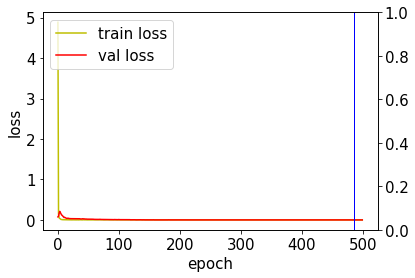

loss: 3846118572032.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [4.0829806  5.1635704  3.0383942  0.39395097]
E1 : 6.649251614047357, E2 : 0.8778932210138484, E2M : 0.877735232164551, E2v : 0.00015798884929716042
(2800, 4)


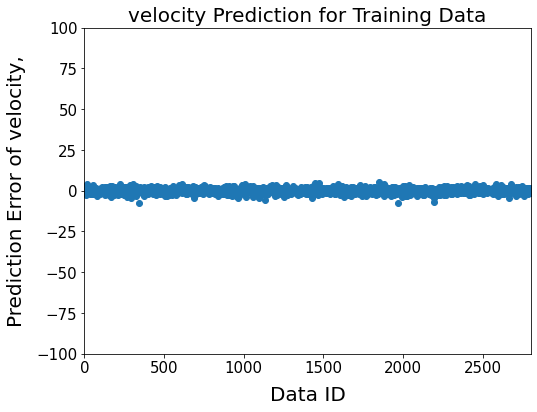

std : 1.252658329247298, max : 5.088484287261963, min : -7.331812381744385
################################################################################ target : 2, fold : 1 ################################################################################
Epoch 1/500
5/5 - 0s - loss: 10.3825 - val_loss: 0.5910 - lr: 0.0010
Epoch 2/500
5/5 - 0s - loss: 0.7331 - val_loss: 2.0973 - lr: 0.0010
Epoch 3/500
5/5 - 0s - loss: 0.1582 - val_loss: 2.9155 - lr: 0.0010
Epoch 4/500
5/5 - 0s - loss: 0.1344 - val_loss: 3.1373 - lr: 0.0010
Epoch 5/500
5/5 - 0s - loss: 0.0555 - val_loss: 2.9868 - lr: 0.0010
Epoch 6/500
5/5 - 0s - loss: 0.0449 - val_loss: 2.9949 - lr: 0.0010
Epoch 7/500
5/5 - 0s - loss: 0.0250 - val_loss: 2.7750 - lr: 0.0010
Epoch 8/500
5/5 - 0s - loss: 0.0185 - val_loss: 2.4945 - lr: 0.0010
Epoch 9/500
5/5 - 0s - loss: 0.0130 - val_loss: 2.4331 - lr: 0.0010
Epoch 10/500
5/5 - 0s - loss: 0.0079 - val_loss: 2.2841 - lr: 0.0010
Epoch 11/500

Epoch 00011: ReduceLROnPlateau reducing learni

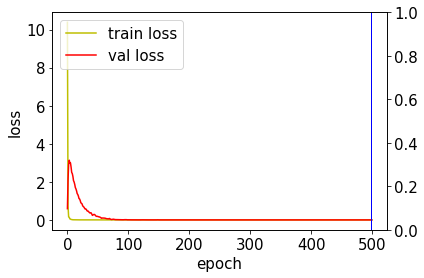

loss: 185338265600.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [ 0.4208262 -1.0257244  2.2731173  0.4071476]
E1 : 6.65407304823733, E2 : 0.9184490984087367, E2M : 0.9181173634156562, E2v : 0.0003317349930803558
(2800, 4)


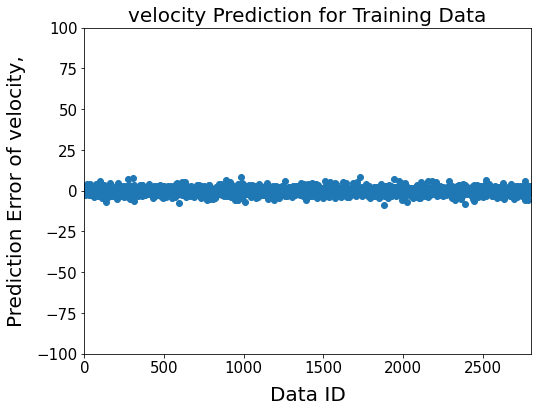

std : 1.8171355416958126, max : 8.304291963577265, min : -8.478707075119024
################################################################################ target : 2, fold : 2 ################################################################################
Epoch 1/500
5/5 - 0s - loss: 31.5294 - val_loss: 0.1685 - lr: 0.0010
Epoch 2/500
5/5 - 0s - loss: 0.1570 - val_loss: 0.0311 - lr: 0.0010
Epoch 3/500
5/5 - 0s - loss: 0.0694 - val_loss: 0.0305 - lr: 0.0010
Epoch 4/500
5/5 - 0s - loss: 0.0331 - val_loss: 0.0699 - lr: 0.0010
Epoch 5/500
5/5 - 0s - loss: 0.0272 - val_loss: 0.1420 - lr: 0.0010
Epoch 6/500
5/5 - 0s - loss: 0.0136 - val_loss: 0.1997 - lr: 0.0010
Epoch 7/500
5/5 - 0s - loss: 0.0112 - val_loss: 0.1845 - lr: 0.0010
Epoch 8/500
5/5 - 0s - loss: 0.0082 - val_loss: 0.1941 - lr: 0.0010
Epoch 9/500
5/5 - 0s - loss: 0.0065 - val_loss: 0.2141 - lr: 0.0010
Epoch 10/500
5/5 - 0s - loss: 0.0040 - val_loss: 0.2230 - lr: 0.0010
Epoch 11/500
5/5 - 0s - loss: 0.0033 - val_loss: 0.2226 - l

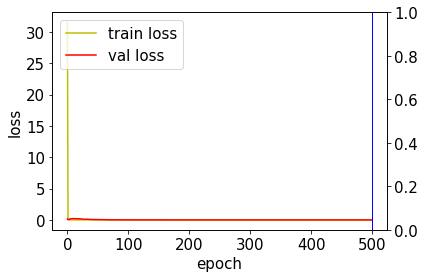

loss: 1892640358400.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [ 4.2472167  -8.933483    0.3426267   0.39655757]
E1 : 6.6395674090842345, E2 : 0.9926353760936694, E2M : 0.9921351919421418, E2v : 0.0005001841515273866
(2800, 4)


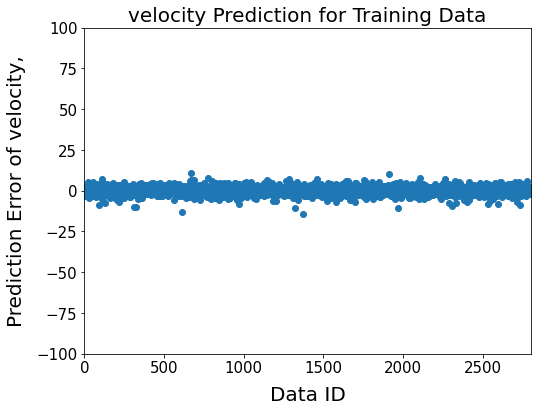

std : 2.2225769484473843, max : 10.956564545631403, min : -14.48777168989182
################################################################################ target : 2, fold : 3 ################################################################################
Epoch 1/500
5/5 - 0s - loss: 9.2309 - val_loss: 0.4989 - lr: 0.0010
Epoch 2/500
5/5 - 0s - loss: 0.2469 - val_loss: 0.3825 - lr: 0.0010
Epoch 3/500
5/5 - 0s - loss: 0.0620 - val_loss: 0.2316 - lr: 0.0010
Epoch 4/500
5/5 - 0s - loss: 0.0385 - val_loss: 0.1978 - lr: 0.0010
Epoch 5/500
5/5 - 0s - loss: 0.0236 - val_loss: 0.1555 - lr: 0.0010
Epoch 6/500
5/5 - 0s - loss: 0.0144 - val_loss: 0.0924 - lr: 0.0010
Epoch 7/500
5/5 - 0s - loss: 0.0115 - val_loss: 0.0610 - lr: 0.0010
Epoch 8/500
5/5 - 0s - loss: 0.0093 - val_loss: 0.0596 - lr: 0.0010
Epoch 9/500
5/5 - 0s - loss: 0.0057 - val_loss: 0.0394 - lr: 0.0010
Epoch 10/500
5/5 - 0s - loss: 0.0132 - val_loss: 0.0356 - lr: 0.0010
Epoch 11/500
5/5 - 0s - loss: 0.0146 - val_loss: 0.0441 - l

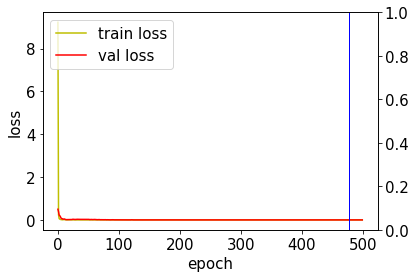

loss: 286197481472.0
정답(original): [   0.  -400.    50.     0.4], 예측값(original):, [-1.2953862  2.075749   0.936539   0.4073099]
E1 : 6.650362403186995, E2 : 0.9511930355759205, E2M : 0.9509298010401281, E2v : 0.00026323453579238615
(2800, 4)


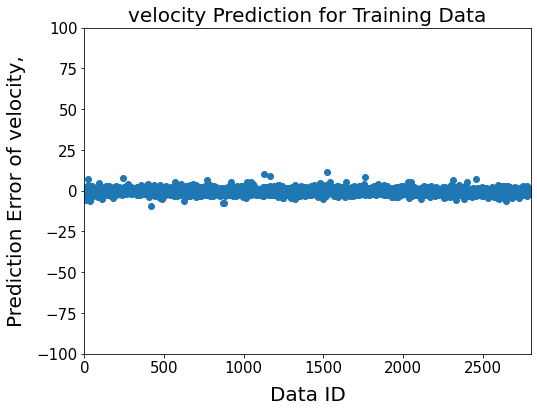

std : 1.6103285004347718, max : 11.52651309967041, min : -9.088060259819036
################################################################################ target : 2, fold : 4 ################################################################################


In [11]:
if 'submit' not in globals(): submit=pd.read_csv('../data/sample_submission.csv')
if 'metrics' not in globals(): metrics = {}

seed_everything(SEED)
nf_list = [16, 16, 16]
for train_target in range(3):
    fold_metrics = {}
    for k in range(N_FOLDS):
        model = set_model(train_target, nf=nf_list[train_target])
        train(model, X_train_l[train_target], Y_train, train_target, n_fold=N_FOLDS, fold=k, seed=SEED)
        
        best_model, fold_metrics[k] = load_best_model(train_target, k)
        pred_data_test = best_model.predict(X_test_l[train_target])

        if k==0:
            if train_target == 0: # x,y 학습
                submit.iloc[:,1] = pred_data_test[:,0]/N_FOLDS
                submit.iloc[:,2] = pred_data_test[:,1]/N_FOLDS
            elif train_target == 1: # m 학습
                submit.iloc[:,3] = pred_data_test[:,2]/N_FOLDS
            elif train_target == 2: # v 학습
                submit.iloc[:,4] = pred_data_test[:,3]/N_FOLDS
        else:
            if train_target == 0: # x,y 학습
                submit.iloc[:,1] += pred_data_test[:,0]/N_FOLDS
                submit.iloc[:,2] += pred_data_test[:,1]/N_FOLDS
            elif train_target == 1: # m 학습
                submit.iloc[:,3] += pred_data_test[:,2]/N_FOLDS
            elif train_target == 2: # v 학습
                submit.iloc[:,4] += pred_data_test[:,3]/N_FOLDS
        print(f'################################################################################ target : {train_target}, fold : {k} ################################################################################')
    metrics[train_target] = fold_metrics

# wavenet

In [7]:
import os
import json
import random
import math
from tqdm.notebook import tqdm
import warnings
import gc

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import f1_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

def read_data(debar=375):
    train = pd.read_csv('../data/train_features.csv')
    target = pd.read_csv('../data/train_target.csv')
    test = pd.read_csv('../data/test_features.csv')
    sub = pd.read_csv('../data/sample_submission.csv')
    
    train = train[train.index%375<debar].reset_index(drop=True)
    test = test[test.index%375<debar].reset_index(drop=True)

    for col in ['S1', 'S2', 'S3', 'S4']:
        train[f'speed_{col}'] = train.groupby('id')[col].cumsum().abs().values
        test[f'speed_{col}'] = test.groupby('id')[col].cumsum().abs().values
    return train, target, test, sub

def normalize(train, test):
    for col in ['S1', 'S2', 'S3', 'S4']:
        train_input_mean = train[col].mean()
        train_input_sigma = train[col].std()
        train[col] = (train[col] - train_input_mean) / train_input_sigma
        test[col] = (test[col] - train_input_mean) / train_input_sigma

        col = f'speed_{col}'
        train_input_mean = train[col].mean()
        train_input_sigma = train[col].std()
        train[col] = (train[col] - train_input_mean) / train_input_sigma
        test[col] = (test[col] - train_input_mean) / train_input_sigma
    return train, test

def lag_with_pct_change(df, windows):
    for window in [1, 2, 3]:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df['signal_shift_pos_' + str(window) + col] = df.groupby('id')[col].shift(window).fillna(0)
            df['signal_shift_neg_' + str(window) + col] = df.groupby('id')[col].shift(-1 * window).fillna(0)

    for window in windows:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df[f'{col}_{window}_mean'] = df.groupby('id')[col].rolling(window=window).mean().values
            df[f'{col}_{window}_std'] = df.groupby('id')[col].rolling(window=window).std().values
            df[f'{col}_{window}_var'] = df.groupby('id')[col].rolling(window=window).var().values
            df[f'{col}_{window}_max'] = df.groupby('id')[col].rolling(window=window).max().values
            df[f'{col}_{window}_min'] = df.groupby('id')[col].rolling(window=window).min().values

        for col in ['S1', 'S2', 'S3', 'S4']:
            col = f'speed_{col}'
            df[f'{col}_{window}_mean'] = df.groupby('id')[col].rolling(window=window).mean().values
            df[f'{col}_{window}_std'] = df.groupby('id')[col].rolling(window=window).std().values
            df[f'{col}_{window}_var'] = df.groupby('id')[col].rolling(window=window).var().values
            df[f'{col}_{window}_max'] = df.groupby('id')[col].rolling(window=window).max().values
            df[f'{col}_{window}_min'] = df.groupby('id')[col].rolling(window=window).min().values

    for col in ['S1', 'S2', 'S3', 'S4']:
        df.drop(columns=col, inplace=True)
        df.drop(columns=f'speed_{col}', inplace=True)
            
    df = df.replace([np.inf, -np.inf], np.nan)    
    df.fillna(0, inplace=True)
    return df

def run_feat_engineering(df, batch_size):
    df = lag_with_pct_change(df, [10, 50])
    return df

# fillna with the mean and select features for training
def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'id']]#Time
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        # 나중에 group별로 fillna 하는 걸로 바꿔보자
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

def split(GROUP_BATCH_SIZE=4000, SPLITS=5):
    print('Reading Data Started...')
    train, target, test, sub = read_data(debar=GROUP_BATCH_SIZE)
    train, test = normalize(train, test)
    print('Reading and Normalizing Data Completed')
    print('Creating Features')
    print('Feature Engineering Started...')
    train = run_feat_engineering(train, batch_size=GROUP_BATCH_SIZE)
    test = run_feat_engineering(test, batch_size=GROUP_BATCH_SIZE)
    
    train, test, features = feature_selection(train, test)
    print('Feature Engineering Completed...')
    print(features)

    train = pd.merge(train, target, how='left', on='id')
    group = train['id']
    kf = GroupKFold(n_splits=SPLITS)
    splits = [x for x in kf.split(train, train[['X', 'Y', 'M', 'V']], group)]
    
    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[1])
        new_splits.append(new_split)
    target_cols = ['X', 'Y', 'M', 'V']
    
    target = np.array(list(train.groupby('id').apply(lambda x: x[target_cols].values))).astype(np.float32)
    train = np.array(list(train.groupby('id').apply(lambda x: x[features].values)))
    
    test = np.array(list(test.groupby('id').apply(lambda x: x[features].values)))

    print(train.shape, test.shape, target.shape)
    return train, test, target, new_splits

In [9]:
class Wave_Block(nn.Module):
    def __init__(self,in_channels,out_channels,dilation_rates):
        super(Wave_Block,self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.convs.append(nn.Conv1d(in_channels,out_channels,kernel_size=1))
        dilation_rates = [2**i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            self.filter_convs.append(nn.Conv1d(out_channels,out_channels,kernel_size=3,padding=dilation_rate,dilation=dilation_rate))
            self.gate_convs.append(nn.Conv1d(out_channels,out_channels,kernel_size=3,padding=dilation_rate,dilation=dilation_rate))
            self.convs.append(nn.Conv1d(out_channels,out_channels,kernel_size=1))
    def forward(self,x):
        x = self.convs[0](x)
        res = x
        for i in range(self.num_rates):
            x = F.tanh(self.filter_convs[i](x))*F.sigmoid(self.gate_convs[i](x))
            x = self.convs[i+1](x)
            res = torch.add(res, x)
        return res

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        # For normal input
        self.wave_block1 = Wave_Block(105,64,12)
        self.bn_1 = nn.BatchNorm1d(64)

        self.wave_block2 = Wave_Block(64,32,8)
        self.bn_2 = nn.BatchNorm1d(32)

        self.wave_block3 = Wave_Block(32,64,4)
        self.bn_3 = nn.BatchNorm1d(64)

        self.wave_block4 = Wave_Block(64,128,1)
        self.bn_4 = nn.BatchNorm1d(128)

        self.fc = nn.Linear(128, 4)

    def flip(self, x, dim):
        dim = x.dim() + dim if dim < 0 else dim
        return x[tuple(slice(None, None) if i != dim
                 else torch.arange(x.size(i)-1, -1, -1).long()
                 for i in range(x.dim()))]
    
    def forward(self,x):
        x = x.permute(0, 2, 1)
        # forward input
        x = self.wave_block1(x)
        x = self.bn_1(x)
        x = self.wave_block2(x)
        x = self.bn_2(x)
        x = self.wave_block3(x)
        x = self.bn_3(x)
        x = self.wave_block4(x)
        x = self.bn_4(x)

        x = torch.mean(x, axis=2)
        x = self.fc(x)

        return x
    
class EarlyStopping:
    def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pt', is_maximize=True):
        self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
        self.counter, self.best_score = 0, None
        self.is_maximize = is_maximize
    def load_best_weights(self, model):
        model.load_state_dict(torch.load(self.checkpoint_path))
    def __call__(self, score, model):
        if self.best_score is None or \
                (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
            torch.save(model.state_dict(), self.checkpoint_path)
            self.best_score, self.counter = score, 0
            return 1
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return 2
        return 0

class IronDataset(Dataset):
    def __init__(self, data, labels, training=True, transform=False, seq_len=5000, flip=False, noise_level=0, class_split=0.0):
        
        if flip:
            self.data = np.flip(data)
            self.labels = np.flip(labels)
        else:
            self.data = data
            self.labels = labels.mean(1)
        
        self.transform = transform
        self.training = training
        self.flip = flip
        self.noise_level = noise_level
        self.class_split = class_split
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        data = self.data[idx]
        labels = self.labels[idx]
        return [data.astype(np.float32), labels.astype(np.float32)]

def kaeri_metric(y_true, y_pred):
    return 0.5 * E1(y_true, y_pred) + 0.5 * E2(y_true, y_pred)
def E1(y_true, y_pred):
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)
def E2(y_true, y_pred):
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))

def torch_kaeri_metric(y_true, y_pred):
    return 0.5 * torch_E1(y_true, y_pred) + 0.5 * torch_E2(y_true, y_pred)
def torch_E1(y_true, y_pred):
    _t, _p = y_true[:,:2], y_pred[:,:2]
    return torch.mean(torch.sum(torch.square(_t - _p), axis = 1) / 2e+04)
def torch_E2(y_true, y_pred):
    _t, _p = y_true[:,2:], y_pred[:,2:]
    return torch.mean(torch.sum(torch.square((_t - _p) / (_t + 1e-06)), axis = 1))

In [10]:
%%time
GROUP_BATCH_SIZE=200
train, test, train_tr, new_splits = split(GROUP_BATCH_SIZE=GROUP_BATCH_SIZE)

Reading Data Started...
Reading and Normalizing Data Completed
Creating Features
Feature Engineering Started...
Feature Engineering Completed...
['Time', 'signal_shift_pos_1S1', 'signal_shift_neg_1S1', 'signal_shift_pos_1S2', 'signal_shift_neg_1S2', 'signal_shift_pos_1S3', 'signal_shift_neg_1S3', 'signal_shift_pos_1S4', 'signal_shift_neg_1S4', 'signal_shift_pos_2S1', 'signal_shift_neg_2S1', 'signal_shift_pos_2S2', 'signal_shift_neg_2S2', 'signal_shift_pos_2S3', 'signal_shift_neg_2S3', 'signal_shift_pos_2S4', 'signal_shift_neg_2S4', 'signal_shift_pos_3S1', 'signal_shift_neg_3S1', 'signal_shift_pos_3S2', 'signal_shift_neg_3S2', 'signal_shift_pos_3S3', 'signal_shift_neg_3S3', 'signal_shift_pos_3S4', 'signal_shift_neg_3S4', 'S1_10_mean', 'S1_10_std', 'S1_10_var', 'S1_10_max', 'S1_10_min', 'S2_10_mean', 'S2_10_std', 'S2_10_var', 'S2_10_max', 'S2_10_min', 'S3_10_mean', 'S3_10_std', 'S3_10_var', 'S3_10_max', 'S3_10_min', 'S4_10_mean', 'S4_10_std', 'S4_10_var', 'S4_10_max', 'S4_10_min', 'speed

In [11]:
NNBATCHSIZE = 256
flip = False
noise = False
LR = 0.0015
EPOCHS = 200
outdir = ''

In [ ]:
seed_everything(42)
test_y = np.zeros([int(262500/GROUP_BATCH_SIZE), GROUP_BATCH_SIZE, 4])
test_dataset = IronDataset(test, test_y, flip=flip)
test_dataloader = DataLoader(test_dataset, NNBATCHSIZE, shuffle=False, num_workers=8, pin_memory=True)

for index, (train_index, val_index, _) in enumerate(new_splits[0:], start=0):
    print("Fold : {}".format(index))
    train_dataset = IronDataset(train[train_index], train_tr[train_index], seq_len=GROUP_BATCH_SIZE, flip=flip, noise_level=False, transform=False)
    train_dataloader = DataLoader(train_dataset, NNBATCHSIZE, shuffle=True, num_workers=8, pin_memory=True)

    valid_dataset = IronDataset(train[val_index], train_tr[val_index], seq_len=GROUP_BATCH_SIZE, flip=flip)
    valid_dataloader = DataLoader(valid_dataset, NNBATCHSIZE, shuffle=False, num_workers=4, pin_memory=True)

    model = Regressor()
    model = model.cuda()

    early_stopping = EarlyStopping(patience=50, is_maximize=False, checkpoint_path=os.path.join(outdir, f'fold_{index}.pt'))
    
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.000025)
    schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=5, factor=0.9)

    criterion = nn.L1Loss()
    score = 10000000

    for epoch in range(EPOCHS):
        train_loss, valid_loss = 0, 0
        custom_trn_loss, custom_val_loss = 0, 0

        model.train()  # prep model for training

        for (x, y) in train_dataloader:
            x = x.cuda()
            y = y.cuda()
            
            opt.zero_grad()
            predictions = model(x)
            loss = criterion(predictions, y)
            custom = torch_kaeri_metric(y, predictions)
            loss = loss + custom*2

            loss.backward()
            opt.step()
            custom_trn_loss += custom
        custom_trn_loss = custom_trn_loss / len(train_dataloader)

        # prep model for evaluation
        model.eval()  
        with torch.no_grad():
            for (x, y) in valid_dataloader:
                x = x.cuda()
                y = y.cuda()
                
                predictions = model(x)
                loss = criterion(predictions, y)
                custom = torch_kaeri_metric(y, predictions).item()
                
                valid_loss += loss
                custom_val_loss += custom
        
        valid_loss = valid_loss / len(valid_dataloader)
        custom_val_loss = custom_val_loss / len(valid_dataloader)
        
        early_loss = valid_loss + custom_val_loss*2
        res = early_stopping(early_loss, model)
        
        if res==2:
            print("Early Stopping")
            print('folder %d global best val max f1 model score %f' % (index, early_stopping.best_score))
            print ("Epoch [{}/{}], val_loss : {:.4f}, tr_cus_loss : {:.4f}, va_cus_loss : {:.4f}, lr : {:.6f}, early_loss : {:.4f}".
                    format(epoch+1, EPOCHS, valid_loss, custom_trn_loss, custom_val_loss, opt.param_groups[0]['lr'], early_loss))
            break
        elif res==1:
            if score>early_loss:
                score = early_loss
                print ("Epoch [{}/{}], val_loss : {:.4f}, tr_cus_loss : {:.4f}, va_cus_loss : {:.4f}, lr : {:.6f}, early_loss : {:.4f}".
                    format(epoch+1, EPOCHS, valid_loss, custom_trn_loss, custom_val_loss, opt.param_groups[0]['lr'], early_loss))
        
        # 플레쳐
        schedular.step(early_loss)

Fold : 0
Epoch [1/200], val_loss : 133.2395, tr_cus_loss : 4.3740, va_cus_loss : 4.0591, lr : 0.001500, early_loss : 141.3577
Epoch [2/200], val_loss : 132.8398, tr_cus_loss : 4.0550, va_cus_loss : 3.9247, lr : 0.001500, early_loss : 140.6892
Epoch [3/200], val_loss : 131.8441, tr_cus_loss : 3.9552, va_cus_loss : 3.7708, lr : 0.001500, early_loss : 139.3857
Epoch [4/200], val_loss : 129.9709, tr_cus_loss : 3.8575, va_cus_loss : 3.6246, lr : 0.001500, early_loss : 137.2200
Epoch [5/200], val_loss : 127.1900, tr_cus_loss : 3.7650, va_cus_loss : 3.6096, lr : 0.001500, early_loss : 134.4092
Epoch [8/200], val_loss : 126.9824, tr_cus_loss : 3.5537, va_cus_loss : 3.4313, lr : 0.001500, early_loss : 133.8450
Epoch [9/200], val_loss : 126.6313, tr_cus_loss : 3.5017, va_cus_loss : 3.4152, lr : 0.001500, early_loss : 133.4616
Epoch [10/200], val_loss : 125.0991, tr_cus_loss : 3.4618, va_cus_loss : 3.3293, lr : 0.001500, early_loss : 131.7577
Epoch [11/200], val_loss : 124.5904, tr_cus_loss : 3.3

In [ ]:
seed_everything(42)
n_folds = 5
test_y = np.zeros([700, 4])
test_dataset = IronDataset(test, test_y, flip=flip)
test_dataloader = DataLoader(test_dataset, NNBATCHSIZE, shuffle=False, num_workers=8, pin_memory=True)

oof_mae = 0
oof_custom = 0

for index, (train_index, val_index, _) in enumerate(new_splits[0:], start=0):
    print("Fold : {}".format(index))
    valid_dataset = IronDataset(train[val_index], train_tr[val_index], seq_len=GROUP_BATCH_SIZE, flip=flip)
    valid_dataloader = DataLoader(valid_dataset, NNBATCHSIZE, shuffle=False, num_workers=4, pin_memory=True)

    model = Regressor()
    model = model.cuda()
    model.load_state_dict(torch.load(outdir + f'fold_{index}.pt'))

    model.eval()  # prep model for evaluation
    oof = []
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.cuda()
            y = y.cuda()
            
            pred = model(x)
            pred = pred.detach().cpu().numpy()
            oof += [pred]

    with torch.no_grad():
        for i, (x, y) in enumerate(test_dataloader):
            x = x.cuda()
            y = y.cuda()

            predictions = model(x)
            predictions = predictions.detach().cpu().numpy()

            test_y[NNBATCHSIZE*i:NNBATCHSIZE*(i+1), :] += predictions / n_folds

    valid_oof = np.concatenate(oof)
    valid_ture = train_tr[val_index].mean(1)
    print('mae : {:.6f}, custom_metirc : {:.6f}'.format(mean_absolute_error(valid_ture, valid_oof), kaeri_metric(valid_ture, valid_oof)))
    
    oof_mae += mean_absolute_error(valid_ture, valid_oof) / n_folds
    oof_custom += kaeri_metric(valid_ture, valid_oof) / n_folds
print(oof_mae, oof_custom)

In [ ]:
submit.iloc[:, 1:] = test_y
wavenet_submit = submit.copy()

# pseudo cnn

In [11]:
def read_data(window_sizes=[[], [], []]):
    train_df = pd.read_csv('../data/train_features.csv')
    target_df = pd.read_csv('../data/train_target.csv')
    test_df = pd.read_csv('../data/test_features.csv')
    train_df = train_df[train_df.index%375<thres].reset_index(drop=True)
    test_df = test_df[test_df.index%375<thres].reset_index(drop=True)

    X_train_l, X_test_l = [], []
    Y_train = target_df.values[:, 1:]

    # making XY
    train = train_df.copy()
    test = test_df.copy()
    for col in ['S1', 'S2', 'S3', 'S4']:
        train[f'speed_{col}'] = train.groupby('id')[col].cumsum().abs().values
        test[f'speed_{col}'] = test.groupby('id')[col].cumsum().abs().values
    train, test = normalize(train, test)
    train = lag_with_pct_change0(train, window_sizes[0])
    test = lag_with_pct_change0(test, window_sizes[0])

    X_train = train.values.reshape((2800,thres,-1,1))
    X_test = test.values.reshape((700,thres,-1,1))
    X_train_l += [X_train]
    X_test_l += [X_test]

    # making M
    train = train_df.copy()
    test = test_df.copy()
    for col in ['S1', 'S2', 'S3', 'S4']:
        train[f'speed_{col}'] = train.groupby('id')[col].cumsum().abs().values
        test[f'speed_{col}'] = test.groupby('id')[col].cumsum().abs().values
    train, test = normalize(train, test)
    train = lag_with_pct_change1(train, window_sizes[1])
    test = lag_with_pct_change1(test, window_sizes[1])

    X_train = train.values.reshape((2800,thres,-1,1))
    X_test = test.values.reshape((700,thres,-1,1))
    X_train_l += [X_train]
    X_test_l += [X_test]

    # making V
    train = train_df.copy()
    test = test_df.copy()

    train, test = normalize(train, test)
    train = lag_with_pct_change2(train, window_sizes[2])
    test = lag_with_pct_change2(test, window_sizes[2])
    
    X_train = train.values.reshape((2800,thres,-1,1))
    X_test = test.values.reshape((700,thres,-1,1))
    X_train_l += [X_train]
    X_test_l += [X_test]

    for i in range(3):
        if i==0:
            print(f'Y_train.shape : {Y_train.shape}')
        print(f'train shape {i} : {X_train_l[i].shape}, test shape {i} : {X_test_l[i].shape}')
    return X_train_l, Y_train, X_test_l

In [12]:
def lag_with_pct_change0(df, windows=[]):
    for window in [1, 2, 3]:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df['signal_shift_pos_' + str(window) + col] = df.groupby('id')[col].shift(window).fillna(0)
            df['signal_shift_neg_' + str(window) + col] = df.groupby('id')[col].shift(-1 * window).fillna(0)
    for window in windows:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df[f'{col}_{window}_mean'] = df.groupby('id')[col].rolling(window=window).mean().values
            df[f'{col}_{window}_std'] = df.groupby('id')[col].rolling(window=window).std().values
            df[f'{col}_{window}_var'] = df.groupby('id')[col].rolling(window=window).var().values
            df[f'{col}_{window}_max'] = df.groupby('id')[col].rolling(window=window).max().values
            df[f'{col}_{window}_min'] = df.groupby('id')[col].rolling(window=window).min().values
    df.drop(columns='id', inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    return df
##############################################################################################################################
def lag_with_pct_change1(df, windows=[]):
    for window in [1, 2, 3]:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df['signal_shift_pos_' + str(window) + col] = df.groupby('id')[col].shift(window).fillna(0)
            df['signal_shift_neg_' + str(window) + col] = df.groupby('id')[col].shift(-1 * window).fillna(0)
        for col in [f'speed_{c}' for c in ['S1', 'S2', 'S3', 'S4']]:
            df['signal_shift_pos_' + str(window) + col] = df.groupby('id')[col].shift(window).fillna(0)
            df['signal_shift_neg_' + str(window) + col] = df.groupby('id')[col].shift(-1 * window).fillna(0)
    for window in windows:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df[f'{col}_{window}_mean'] = df.groupby('id')[col].rolling(window=window).mean().values
            df[f'{col}_{window}_std'] = df.groupby('id')[col].rolling(window=window).std().values
            df[f'{col}_{window}_var'] = df.groupby('id')[col].rolling(window=window).var().values
            df[f'{col}_{window}_max'] = df.groupby('id')[col].rolling(window=window).max().values
            df[f'{col}_{window}_min'] = df.groupby('id')[col].rolling(window=window).min().values
    df.drop(columns='id', inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    return df
##############################################################################################################################
def lag_with_pct_change2(df, windows=[]):
    for window in windows:
        for col in ['S1', 'S2', 'S3', 'S4']:
            df[f'{col}_{window}_mean'] = df.groupby('id')[col].rolling(window=window).mean().values
            df[f'{col}_{window}_max'] = df.groupby('id')[col].rolling(window=window).max().values
            df[f'{col}_{window}_min'] = df.groupby('id')[col].rolling(window=window).min().values
    df.drop(columns=['id'], inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    return df
##############################################################################################################################
def normalize(train, test):
    if 'S1' in train.columns:
        for col in ['Time', 'S1', 'S2', 'S3', 'S4']:
            train_input_mean = train[col].mean()
            train_input_sigma = train[col].std()
            train[col] = (train[col] - train_input_mean) / train_input_sigma
            test[col] = (test[col] - train_input_mean) / train_input_sigma
    if 'speed_S1' in train.columns:
        for col in ['speed_S1', 'speed_S2', 'speed_S3', 'speed_S4']:
            train_input_mean = train[col].mean()
            train_input_sigma = train[col].std()
            train[col] = (train[col] - train_input_mean) / train_input_sigma
            test[col] = (test[col] - train_input_mean) / train_input_sigma
    return train, test

In [13]:
def set_model(train_target, nf=16):  # 0:x,y, 1:m, 2:v
    activation = 'elu'
    padding = 'valid'
    model = Sequential()
    
    fs = (3,1)

    model.add(Conv2D(nf,fs, padding=padding, activation=activation, input_shape=X_train_l[train_target].shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*2,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*4,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*8,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*16,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Conv2D(nf*32,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1)))

    model.add(Flatten())
    model.add(Dense(128, activation ='elu'))
    model.add(Dense(64, activation ='elu'))
    model.add(Dense(32, activation ='elu'))
    model.add(Dense(16, activation ='elu'))
    model.add(Dense(4))

    optimizer = keras.optimizers.Adam()

    global weight2
    if train_target == 1: # only for M
        weight2 = np.array([0,0,1,0])
    else: # only for V
        weight2 = np.array([0,0,0,1])
       
    if train_target==0:
        model.compile(loss=my_loss_E1, optimizer=optimizer,)
    else:
        model.compile(loss=my_loss_E2,optimizer=optimizer,)
       
    return model

In [14]:
%%time
thres=200
N_FOLDS=5
MODEL_SAVE_FOLDER_PATH = ''

SEED=42

ws = [[30], [10, 50], [30]]
X_train_l, Y_train, X_test_l = read_data(window_sizes=ws)

Y_train.shape : (2800, 4)
train shape 0 : (2800, 200, 53, 1), test shape 0 : (700, 200, 53, 1)
train shape 1 : (2800, 200, 97, 1), test shape 1 : (700, 200, 97, 1)
train shape 2 : (2800, 200, 17, 1), test shape 2 : (700, 200, 17, 1)
CPU times: user 1min 21s, sys: 4.48 s, total: 1min 25s
Wall time: 1min 25s


In [15]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def plot_error(type_id,pred,true):
    print(pred.shape)

    if type_id == 0:
        _name = 'x_pos'
    elif type_id == 1:
        _name = 'y_pos'
    elif type_id == 2:
        _name = 'mass'
    elif type_id == 3:
        _name = 'velocity'
    elif type_id == 4:
        _name = "distance"
    else:
        _name = 'error'

    x_coord = np.arange(1,pred.shape[0]+1,1)
    if type_id < 2:
        Err_m = (pred[:,type_id] - true[:,type_id])
    elif type_id < 4:
        Err_m = ((pred[:,type_id] - true[:,type_id])/true[:,type_id])*100
    else:
        Err_m = ((pred[:,0]-true[:,0])**2+(pred[:,1]-true[:,1])**2)**0.5

    fig = plt.figure(figsize=(8,6))
    plt.rcParams["font.size"]=15
    plt.scatter(x_coord, Err_m, marker='o')
    plt.title("%s Prediction for Training Data" % _name, size=20)
    plt.xlabel("Data ID", labelpad=10, size=20)
    plt.ylabel("Prediction Error of %s," % _name, labelpad=10, size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylim(-100., 100.)
    plt.xlim(0, pred.shape[0]+1)
    plt.show()
    print('std : {}, max : {}, min : {}'.format(np.std(Err_m), np.max(Err_m), np.min(Err_m)))
    return Err_m

def train(model,X,Y,train_target,n_fold=5,fold=0,seed=42):
    best_save = ModelCheckpoint(MODEL_SAVE_FOLDER_PATH + f'best_pseudo_m{train_target}_{fold}.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.00001, verbose=1)

    kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
    splits = [[i,j] for i,j in kf.split(X)]
    tt, tt_target = X[splits[fold][0]], Y[splits[fold][0]]
    vv, vv_target = X[splits[fold][1]], Y[splits[fold][1]]
    
    # pseudo labeling
    splits2 = [[i,j] for i,j in kf.split(X_test_l[train_target])]
    tt = np.concatenate([tt, X_test_l[train_target][splits2[fold][1]]])
    tt_target = np.concatenate([tt_target, temp_target[splits2[fold][1]]])

    EPOCHS=500 if train_target==2 else 300
    history = model.fit(tt, tt_target, validation_data=(vv, vv_target),
                  epochs=EPOCHS,
                  batch_size=512,
                  shuffle=True,
                  verbose = 2,
                  callbacks=[es, best_save, reduce_lr], )

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.axvline(x=np.argmin(history.history['val_loss']), color='b', linewidth=1)
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()    
    
    return model
def load_best_model(train_target, fold=0):
    if train_target == 0:
        model = load_model(MODEL_SAVE_FOLDER_PATH + f'best_pseudo_m{train_target}_{fold}.hdf5', custom_objects={'my_loss_E1': my_loss, })
    else:
        model = load_model(MODEL_SAVE_FOLDER_PATH + f'best_pseudo_m{train_target}_{fold}.hdf5', custom_objects={'my_loss_E2': my_loss, })

    score = model.evaluate(X_train_l[train_target], Y_train, verbose=0)
    print('loss:', score)

    pred = model.predict(X_train_l[train_target])
    i=0
    print(f'정답(original): {Y_train[i]}, 예측값(original):, {pred[i]}')
    print(f'E1 : {E1(Y_train, pred)}, E2 : {E2(Y_train, pred)}, E2M : {E2M(Y_train, pred)}, E2v : {E2V(Y_train, pred)}')
    
    if train_target ==0:
        plot_error(4,pred,Y_train)
    elif train_target ==1:
        plot_error(2,pred,Y_train)
    elif train_target ==2:
        plot_error(3,pred,Y_train)    
    
    return model, [E1(Y_train, pred), E2(Y_train, pred), E2M(Y_train, pred), E2V(Y_train, pred)]

In [20]:
# pseudo label
# cnn_submit[['X', 'Y']] = cnn_submit[['X', 'Y']].clip(-400, 400)
# wavenet_submit[['X', 'Y']] = wavenet_submit[['X', 'Y']].clip(-400, 400)
# temp_target = (wavenet_submit/2 + cnn_submit/2).values[:, 1:]
temp_target = pd.read_csv('submission_87.csv').values[:, 1:]

In [21]:
submit = pd.read_csv('../data/sample_submission.csv')
metrics = {}

seed_everything(SEED)
nf_list = [16, 16, 16]
for train_target in range(0,1):
    fold_metrics = {}
    for k in range(N_FOLDS):
        model = set_model(train_target, nf=nf_list[train_target])
        train(model, X_train_l[train_target], Y_train, train_target, n_fold=N_FOLDS, fold=k, seed=SEED)
        
        best_model, fold_metrics[k] = load_best_model(train_target, k)
        pred_data_test = best_model.predict(X_test_l[train_target])

        if k==0:
            if train_target == 0: # x,y 학습
                submit.iloc[:,1] = pred_data_test[:,0]/N_FOLDS
                submit.iloc[:,2] = pred_data_test[:,1]/N_FOLDS
            elif train_target == 1: # m 학습
                submit.iloc[:,3] = pred_data_test[:,2]/N_FOLDS
            elif train_target == 2: # v 학습
                submit.iloc[:,4] = pred_data_test[:,3]/N_FOLDS
        else:
            if train_target == 0: # x,y 학습
                submit.iloc[:,1] += pred_data_test[:,0]/N_FOLDS
                submit.iloc[:,2] += pred_data_test[:,1]/N_FOLDS
            elif train_target == 1: # m 학습
                submit.iloc[:,3] += pred_data_test[:,2]/N_FOLDS
            elif train_target == 2: # v 학습
                submit.iloc[:,4] += pred_data_test[:,3]/N_FOLDS
        print(f'################################################################################ target : {train_target}, fold : {k} ################################################################################')
    metrics[train_target] = fold_metrics

Epoch 1/300
5/5 - 2s - loss: 1.4380 - val_loss: 1.5653 - lr: 0.0010
Epoch 2/300
5/5 - 1s - loss: 0.8873 - val_loss: 1.4396 - lr: 0.0010
Epoch 3/300
5/5 - 1s - loss: 0.5821 - val_loss: 1.2420 - lr: 0.0010
Epoch 4/300
5/5 - 1s - loss: 0.3561 - val_loss: 1.0451 - lr: 0.0010
Epoch 5/300
5/5 - 1s - loss: 0.1535 - val_loss: 0.7880 - lr: 0.0010
Epoch 6/300
5/5 - 1s - loss: 0.0548 - val_loss: 0.6597 - lr: 0.0010
Epoch 7/300
5/5 - 1s - loss: 0.0288 - val_loss: 0.5764 - lr: 0.0010
Epoch 8/300
5/5 - 1s - loss: 0.0189 - val_loss: 0.4767 - lr: 0.0010
Epoch 9/300
5/5 - 1s - loss: 0.0125 - val_loss: 0.4508 - lr: 0.0010
Epoch 10/300
5/5 - 1s - loss: 0.0089 - val_loss: 0.4423 - lr: 0.0010
Epoch 11/300
5/5 - 1s - loss: 0.0066 - val_loss: 0.3915 - lr: 0.0010
Epoch 12/300
5/5 - 1s - loss: 0.0047 - val_loss: 0.3653 - lr: 0.0010
Epoch 13/300
5/5 - 1s - loss: 0.0035 - val_loss: 0.3628 - lr: 0.0010
Epoch 14/300
5/5 - 1s - loss: 0.0035 - val_loss: 0.3552 - lr: 0.0010
Epoch 15/300
5/5 - 1s - loss: 0.0024 - val_

KeyboardInterrupt: 

In [ ]:
submit[['X', 'Y']] = submit[['X', 'Y']].clip(-400, 400)
submit['M'] = temp_target[:, 2] + 1.8
submit['V'] = temp_target[:, 3] + 0.0207

In [ ]:
submit.to_csv('submission.csv', index=False)